## Introduction

Purpose:

Predict if credit is "Good" or "Bad"

Business related questions:

- What are some of the features that people with "Good" credit have?
- What is the average age of applicants?
- What is the average amount people have in their checking and savings account?
- What is the most common property type?
- what is the most common sex/status with "Good" credit
- Does an applicant's demographics cause a deviation in the predicted category vs. what category they were actually placed in thus suggesting bias?


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.feature_selection import SelectFromModel

In [2]:
df = pd.read_csv('german.data', sep='\s+')
df.head(2)

,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1.1
0,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
1,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1


In [3]:
column_names = ['checking_account', 'duration_month', 'credit_history', 'credit_purpose','credit_amount','savings_account','present_employment','disposable_income_percent',
 'status_sex','debtors','residence_since','property','age','other_installments', 'housing','credits_at_current_bank','job','dependants','telephone', 'foreign_worker','class']

In [4]:
df.columns = column_names
df.head(2)

,checking_account,duration_month,credit_history,credit_purpose,credit_amount,savings_account,present_employment,disposable_income_percent,status_sex,debtors,...,property,age,other_installments,housing,credits_at_current_bank,job,dependants,telephone,foreign_worker,class
0,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
1,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   checking_account           999 non-null    object
 1   duration_month             999 non-null    int64 
 2   credit_history             999 non-null    object
 3   credit_purpose             999 non-null    object
 4   credit_amount              999 non-null    int64 
 5   savings_account            999 non-null    object
 6   present_employment         999 non-null    object
 7   disposable_income_percent  999 non-null    int64 
 8   status_sex                 999 non-null    object
 9   debtors                    999 non-null    object
 10  residence_since            999 non-null    int64 
 11  property                   999 non-null    object
 12  age                        999 non-null    int64 
 13  other_installments         999 non-null    object
 14  housing   

In [6]:
df.describe()

,duration_month,credit_amount,disposable_income_percent,residence_since,age,credits_at_current_bank,dependants,class
count,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000
mean,20.917918,3273.362362,2.971972,2.843844,35.514515,1.406406,1.155155,1.300300
std,12.055619,2823.365811,1.118802,1.103665,11.337487,0.577639,0.362234,0.458618
min,4.000000,250.000000,1.000000,1.000000,19.000000,1.000000,1.000000,1.000000
25%,12.000000,1368.500000,2.000000,2.000000,27.000000,1.000000,1.000000,1.000000
50%,18.000000,2320.000000,3.000000,3.000000,33.000000,1.000000,1.000000,1.000000
75%,24.000000,3972.500000,4.000000,4.000000,42.000000,2.000000,1.000000,2.000000
max,72.000000,18424.000000,4.000000,4.000000,75.000000,4.000000,2.000000,2.000000


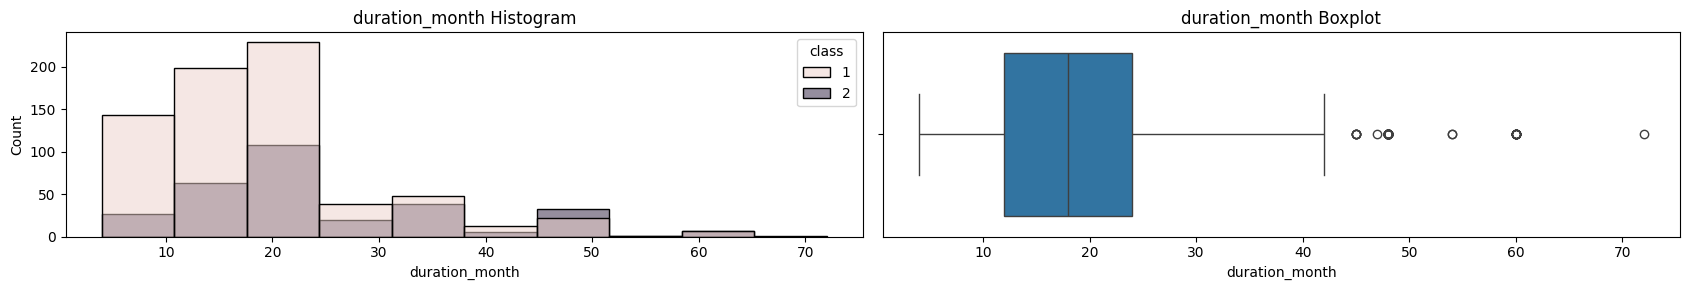

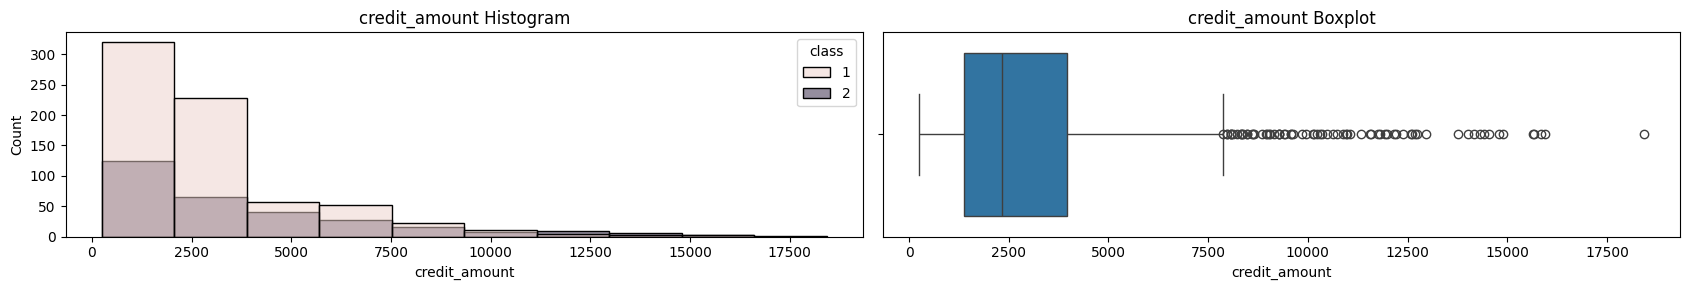

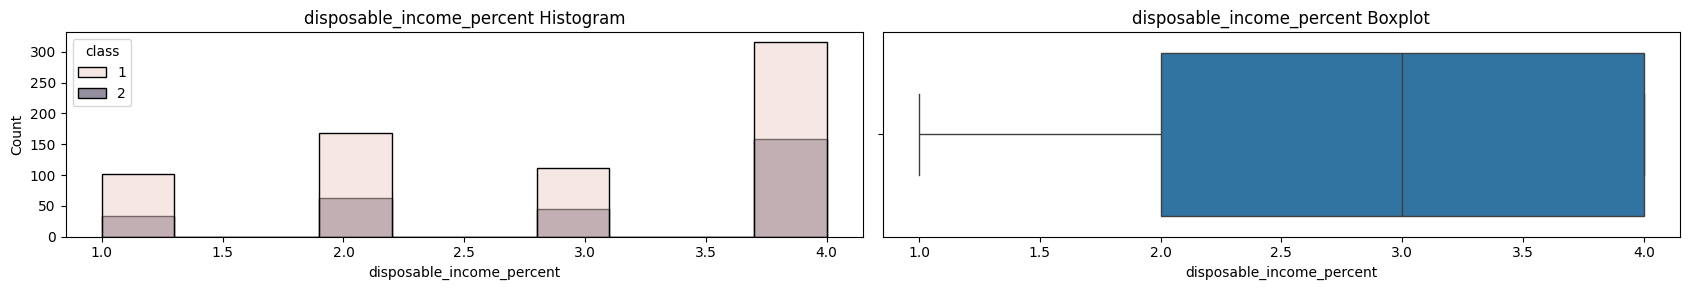

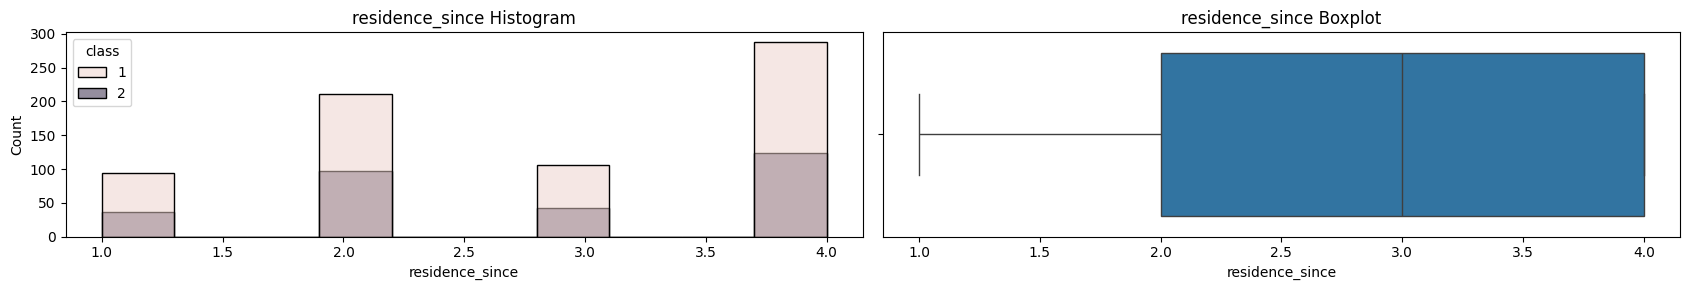

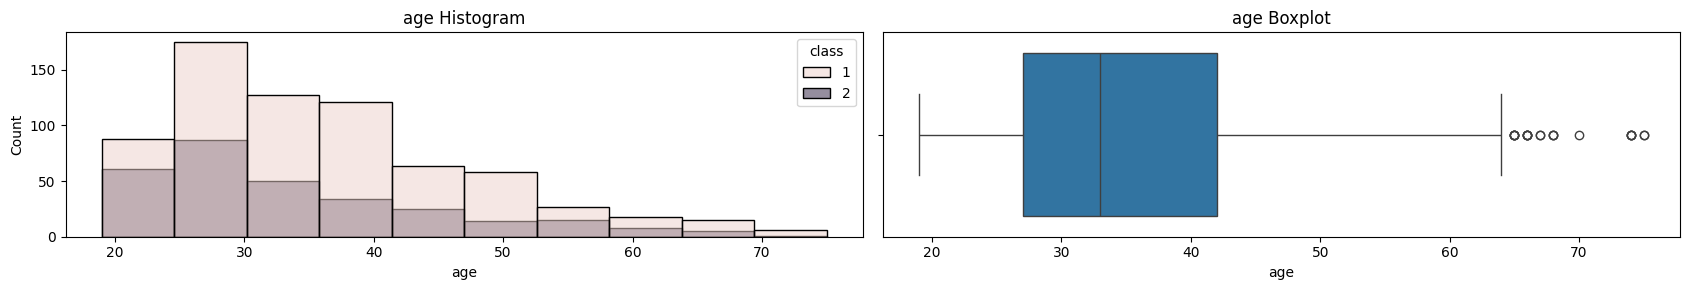

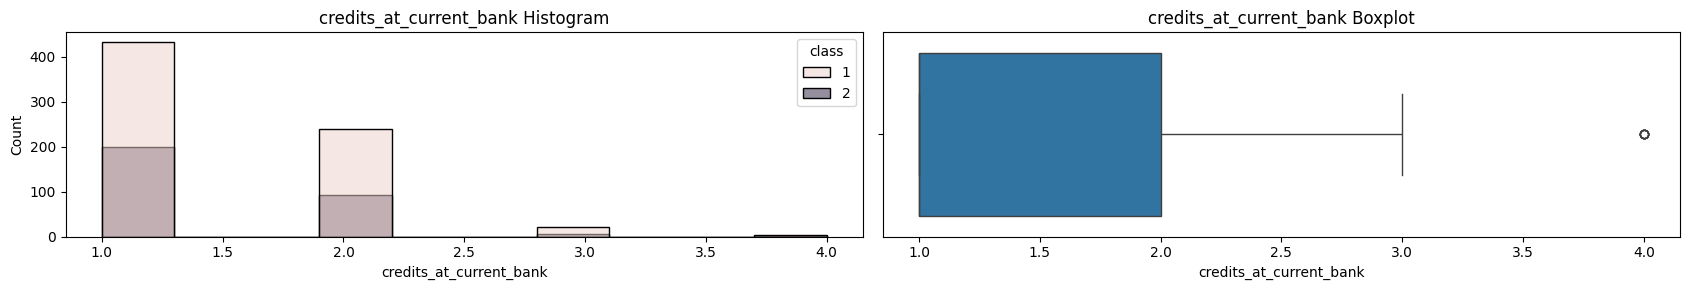

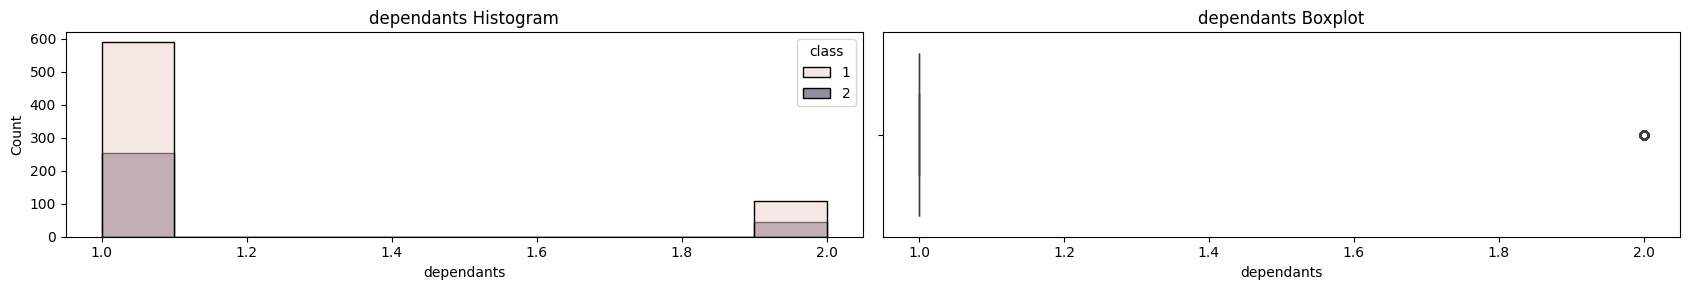

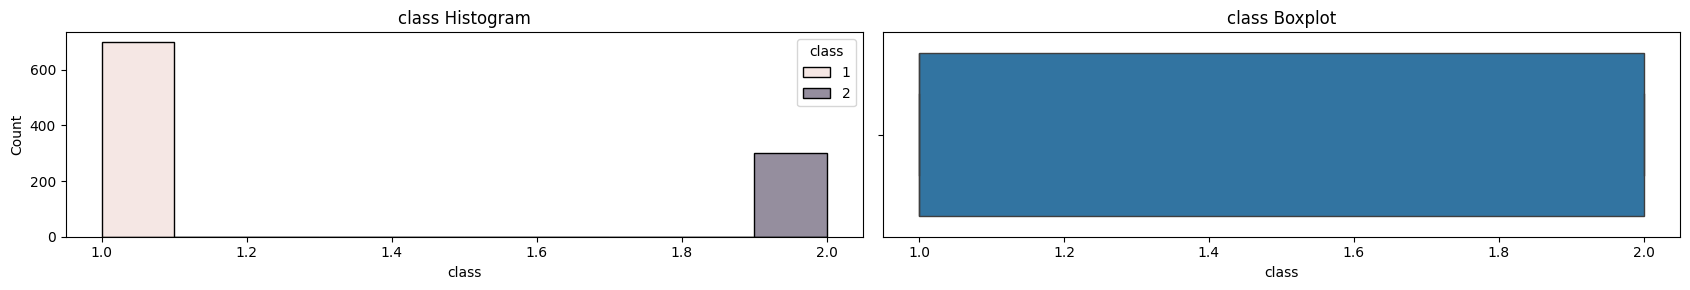

In [7]:
for i in df.columns:
    if df[i].dtype == 'int64':
        fig, ax = plt.subplots(1, 2, figsize=(17, 3))

        sns.histplot(data=df, x=i, bins=10, ax=ax[0], hue='class')
        ax[0].set_title(f'{i} Histogram')
      

        sns.boxplot(data=df, x=i, ax=ax[1])
        ax[1].set_title(f'{i} Boxplot')
   
        plt.tight_layout()
        plt.show();

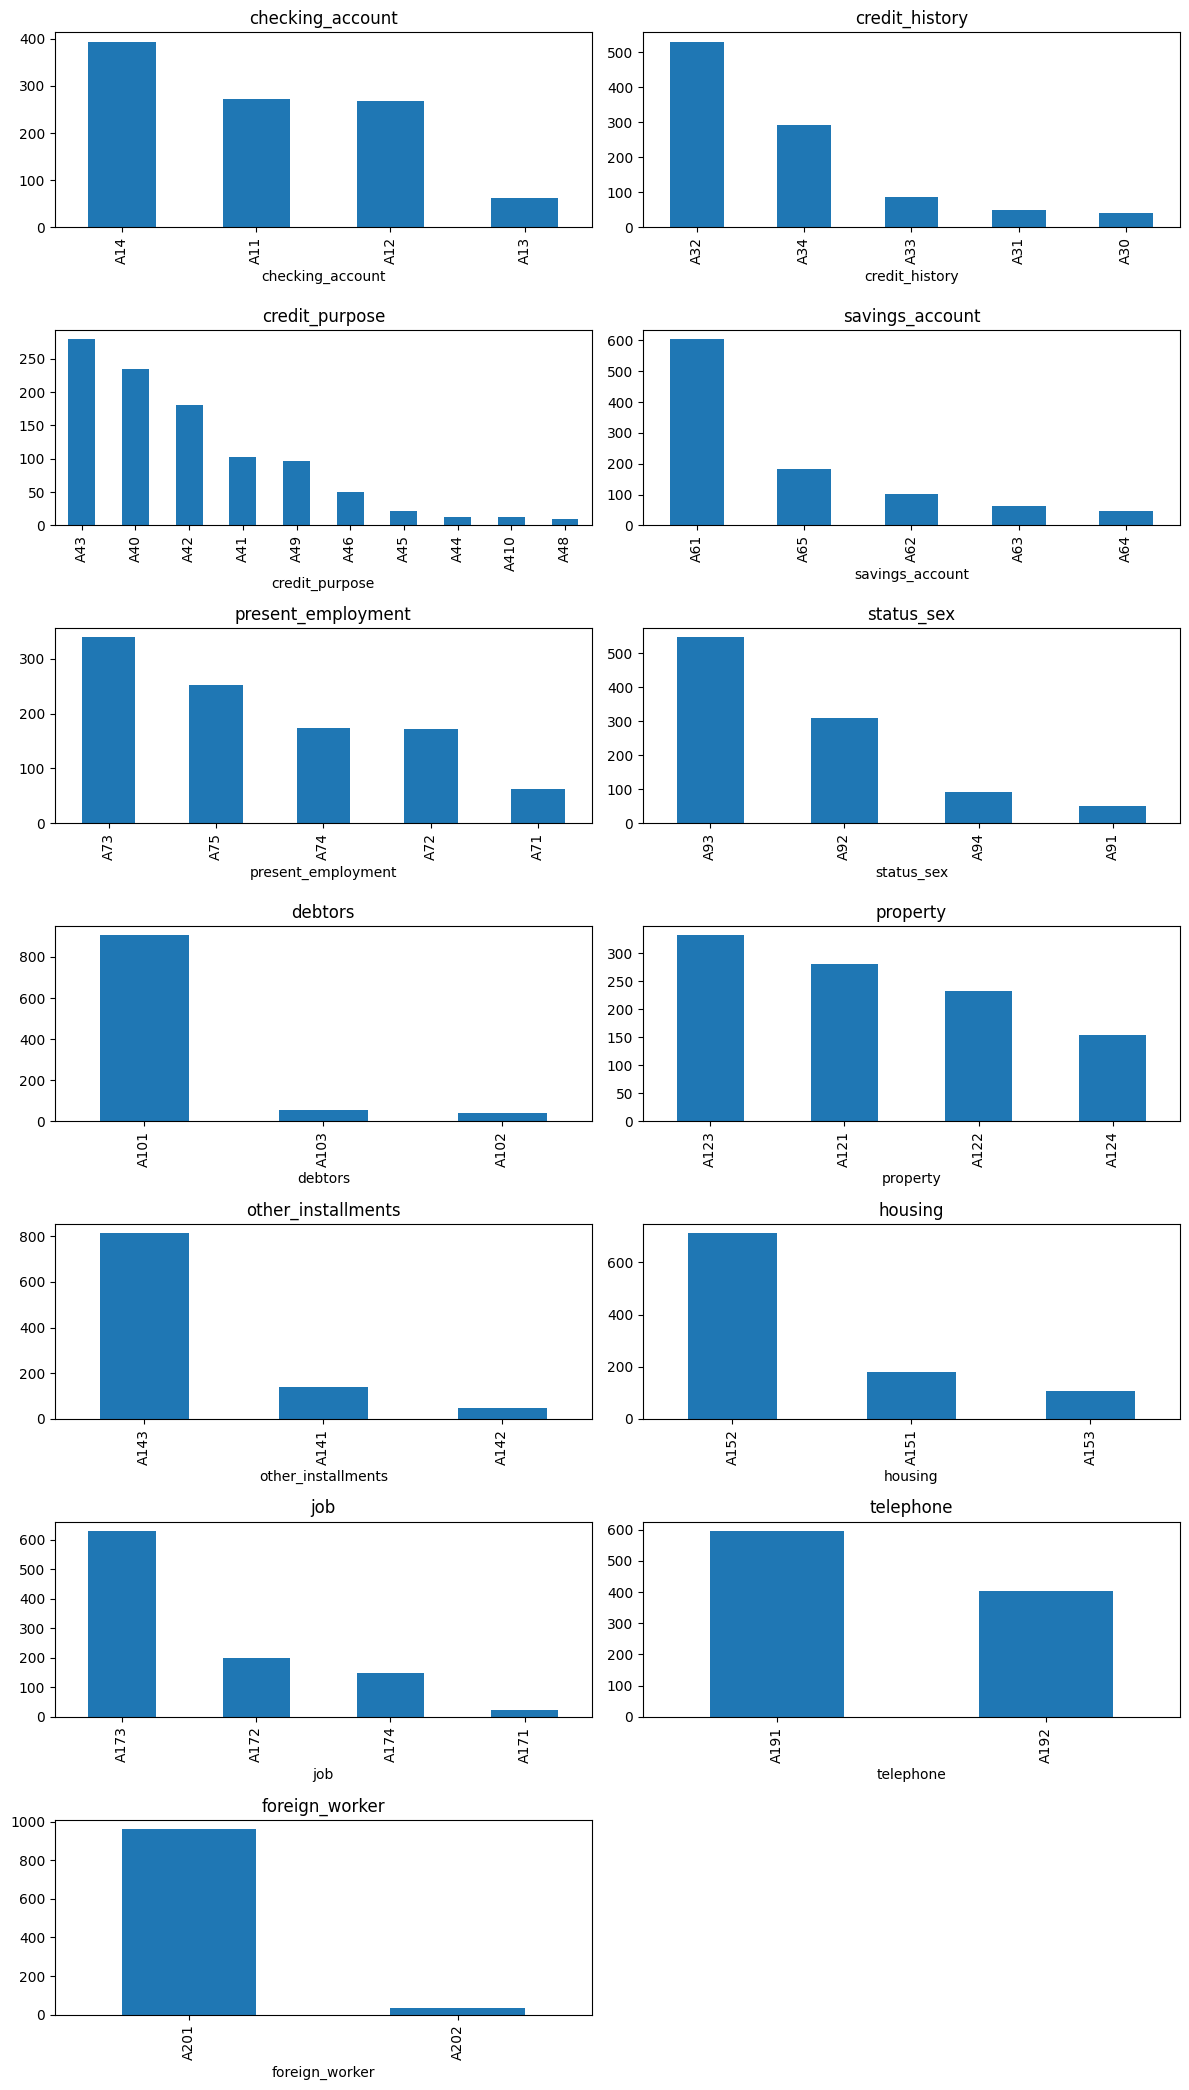

In [8]:
object_columns = df.select_dtypes(include='object').columns

num_rows = (len(object_columns) + 1) // 2  

fig, axes = plt.subplots(num_rows, 2, figsize=(12, 3*num_rows))

axes = axes.flatten()

for i, col in enumerate(object_columns):
    df[col].value_counts().plot(kind='bar', ax=axes[i])
    axes[i].set_title(col)

for i in range(len(object_columns), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

<Axes: >

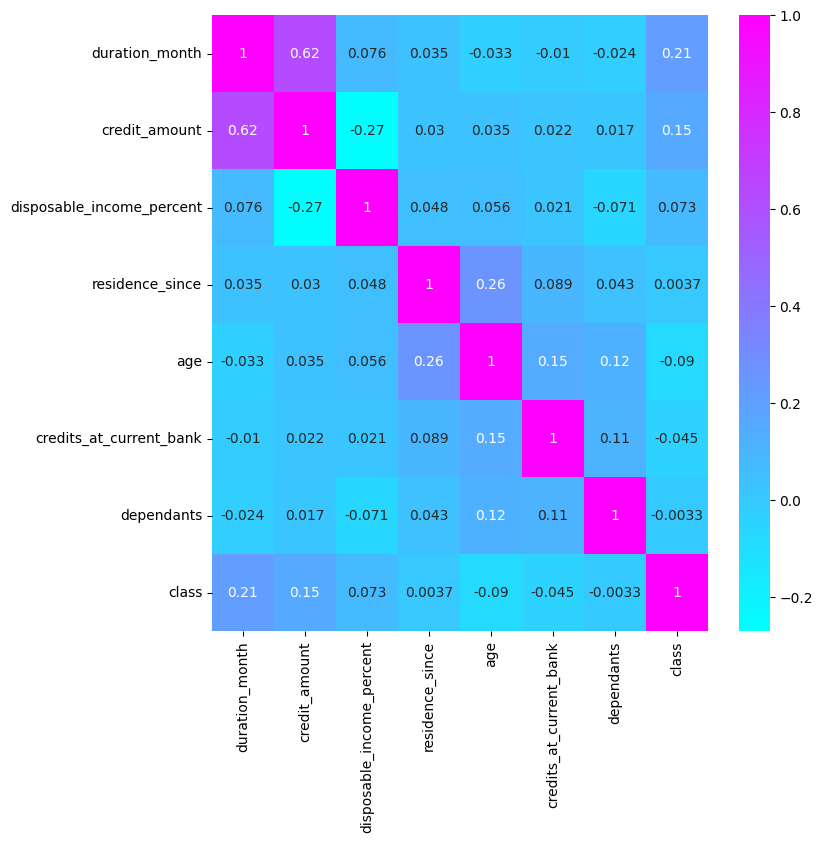

In [9]:
corr_matr = df.corr(numeric_only=True)
plt.figure(figsize=(8,8))
sns.heatmap(corr_matr, cmap= 'cool', annot= True)

### Analayzing Good vs Bad Credit

In [10]:
bad_credit = df[df['class'] == 2]
good_credit = df[df['class'] == 1]

In [11]:
bad_credit.groupby('credits_at_current_bank').mean(numeric_only = True)

,duration_month,credit_amount,disposable_income_percent,residence_since,age,dependants,class
credits_at_current_bank,,,,,,,
1,24.335000,3751.870000,3.150000,2.770000,33.250000,1.135000,2.0
2,26.076087,4313.076087,3.032609,2.956522,35.054348,1.184783,2.0
3,24.000000,4204.000000,2.333333,3.500000,40.833333,1.333333,2.0
4,24.000000,4518.500000,3.000000,4.000000,34.500000,1.000000,2.0


In [12]:
good_credit.groupby('credits_at_current_bank').mean(numeric_only = True)

,duration_month,credit_amount,disposable_income_percent,residence_since,age,dependants,class
credits_at_current_bank,,,,,,,
1,19.166282,2963.034642,2.856813,2.806005,35.247113,1.129330,1.0
2,19.858333,3043.820833,3.029167,2.850000,36.716667,1.179167,1.0
3,13.454545,3008.772727,2.727273,3.272727,45.545455,1.363636,1.0
4,19.500000,2236.750000,4.000000,3.750000,53.500000,1.500000,1.0


***Observations:***
- The **average credit amount** in people with bad credit tends to me more in general in comparison to people with good credit. In other words, bad credit has more accounts open and ask for more money
- The **average age** of people with 4 or more credit accounts at the current bank is 53 years old with good credit and 34.5 years old with bad credit 
- We can drop the dependants and residence_since. These features are very similar between people with good and bad credit. 


In [13]:
df = df.drop(columns=['dependants', 'residence_since'], axis= 1)

**Observation:**

I am dropping Dependats and residence since there is no strong correlation among other variables.

**Savings account/bonds**
 
 A61 :          ... <  100 DM
 
 A62 :   100 <= ... <  500 DM
 
 A63 :   500 <= ... < 1000 DM
 
 A64 :          .. >= 1000 DM

A65 :   unknown/ no savings account

**Status of existing checking account**

A11 :      ... <    0 DM

A12 : 0 <= ... <  200 DM

A13 :      ... >= 200 DM /

salary assignments for at least 1 year

A14 : no checking account

In [14]:
print(f'Good credit:\n{good_credit.savings_account.value_counts()}')
print(f'Bad Credit:\n{bad_credit.savings_account.value_counts()}')
print(f'Good credit:\n{good_credit.checking_account.value_counts()}')
print(f'Bad Credit:\n{bad_credit.checking_account.value_counts()}')

Good credit:
savings_account
A61    386
A65    150
A62     69
A63     52
A64     42
Name: count, dtype: int64
Bad Credit:
savings_account
A61    217
A62     34
A65     32
A63     11
A64      6
Name: count, dtype: int64
Good credit:
checking_account
A14    348
A12    164
A11    138
A13     49
Name: count, dtype: int64
Bad Credit:
checking_account
A11    135
A12    105
A14     46
A13     14
Name: count, dtype: int64


***Observations:***
- The majority of people with good credit do not have checking account at the current bank, while people with bad credit have more accoutns open but have less than 200 DM
- For the people that do have an account open, people with good credit have more than 200 DM in their account

***Maybe We should consider using one-hot encoding on checking and savings account***

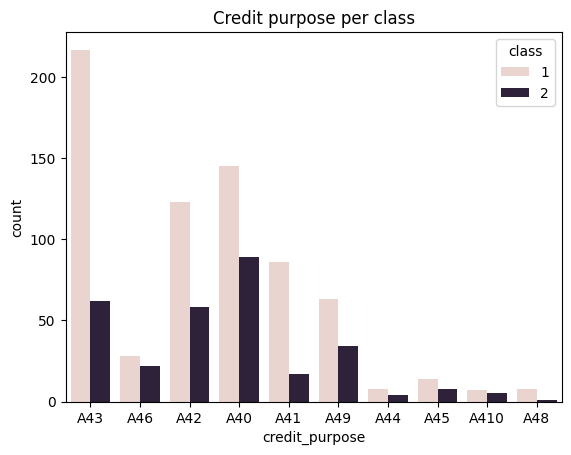

In [15]:
sns.countplot(x ='credit_purpose',hue='class', data= df)
plt.title('Credit purpose per class')
plt.show();

Attribute 4:  (qualitative)

Purpose

A40 : car (new)

A41 : car (used)

A42 : furniture/equipment

A43 : radio/television

A44 : domestic appliances

A45 : repairs

A46 : education

A47 : (vacation - does not exist?)

A48 : retraining

A49 : business

A410 : others


***Observations:***
- Class 1(good) use their credit for radio and televisions, cars and furniture/equipment, while people with bad credit tend to use their credit mostly for purchasing a car

***We should use one-hot encoding for credit purpose***

In [16]:
df_encoded = pd.get_dummies(df, columns=['credit_purpose'], prefix= 'credit_purpose')


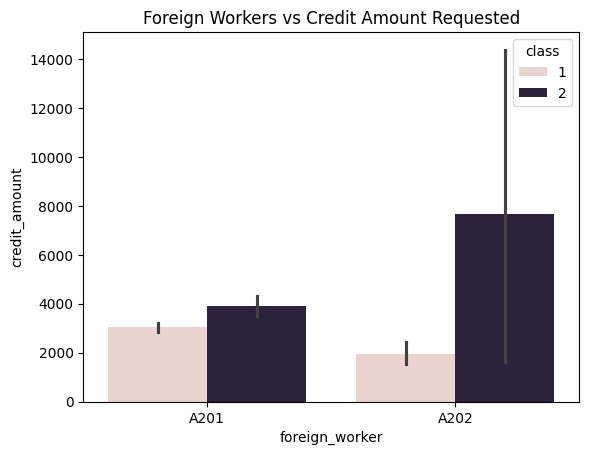

In [17]:
sns.barplot(x = 'foreign_worker', y ='credit_amount', data = df,  hue='class')
plt.title('Foreign Workers vs Credit Amount Requested')
plt.show();

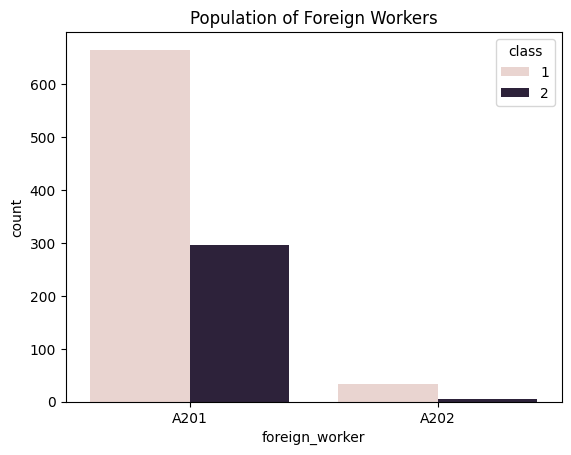

In [18]:
sns.countplot(x=df['foreign_worker'], hue = df['class'])
plt.title('Population of Foreign Workers')
plt.show();

In [19]:
print(df['foreign_worker'].value_counts().sum())
print('---------------------------------')
print(df['foreign_worker'].value_counts()/999)

999
---------------------------------
foreign_worker
A201    0.962963
A202    0.037037
Name: count, dtype: float64


foreign worker:

A201 : yes

A202 : no

***Observations:***
- Foreign workers, tend to ask higher amnounts of credit and tend to have a population with higher bad credit history

- **Since Foreign workers tend to have bad credit we should encode this as well and becasue it composes 96% of our dataset**

In [20]:
# Dropping Foreign Column to Avoid Multicolinearity
df_encoded = pd.get_dummies(df_encoded, columns=['foreign_worker'], drop_first=True, prefix='Foreign') 

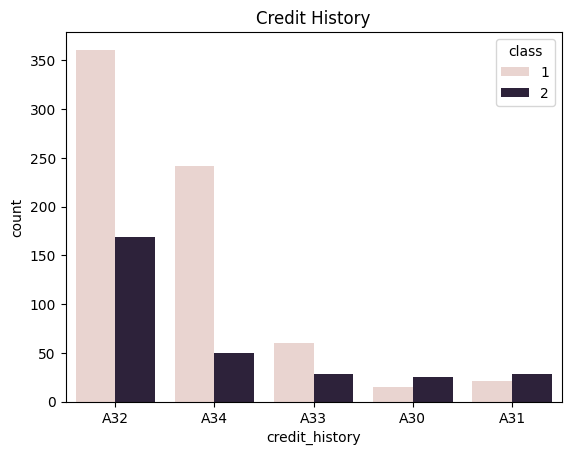

In [21]:
sns.countplot(x = 'credit_history', data=df, hue ='class')
plt.title('Credit History')
plt.show();

Credit history


A30 : no credits taken/

	all credits paid back duly

          

A31 : all credits at this bank paid back duly


A32 : existing credits paid back duly till now

          

A33 : delay in paying off in the past

      

A34 : critical account/
		other credits existing (not at this bank)

***Observations:***
- Although the majority of people with good and bad credit tend to pay off all their debt. There is a significant amount of people with bad debt that have accounts classified as critical in other banks. This could mean that they are looking to get more credit with bad history in other banks


In [22]:
df_encoded = pd.get_dummies(df_encoded, columns=['credit_history'], prefix='credit_history')

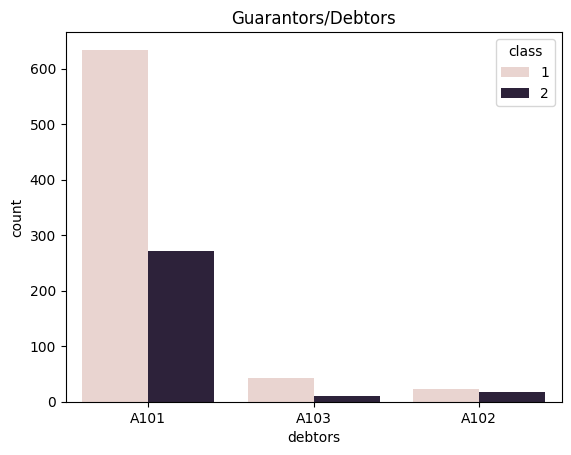

In [23]:
sns.countplot(data=df, x='debtors', hue='class')
plt.title('Guarantors/Debtors')
plt.show()

Other debtors / guarantors

	      A101 : none

	      A102 : co-applicant

	      A103 : guarantor

***We can eliminate this column***

In [24]:
df_encoded = df_encoded.drop(columns= 'debtors', axis=1)

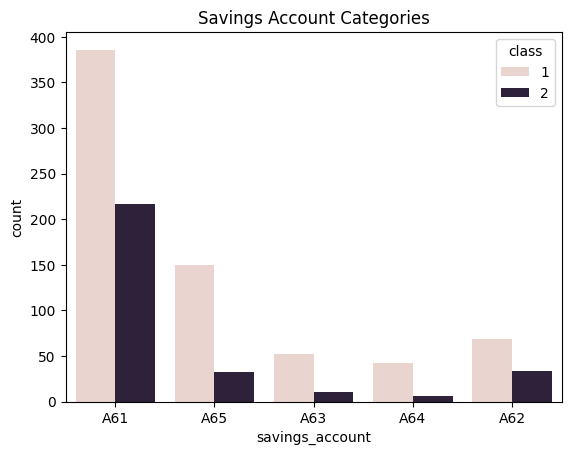

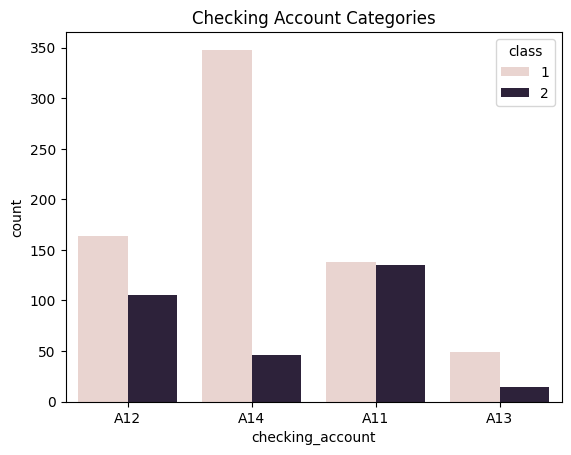

In [25]:
sns.countplot(data = df , x = df['savings_account'], hue='class')
plt.title('Savings Account Categories')
plt.show();
sns.countplot(data = df , x = df['checking_account'], hue='class')
plt.title('Checking Account Categories')
plt.show();

		checking account
		
        A11 :      ... <    0 DM

	    A12 : 0 <= ... <  200 DM

	    A13 :      ... >= 200 DM /
		salary assignments for at least 1 year
		
        A14 : no checking account

  Savings account/bonds

	      A61 :          ... <  100 DM

	      A62 :   100 <= ... <  500 DM

	      A63 :   500 <= ... < 1000 DM

	      A64 :          .. >= 1000 DM
		  
              A65 :   unknown/ no savings account

**We can include checking and savings account feature since it is important for financial institutions to evaluate how much available capital they have**

In [26]:
df_encoded = pd.get_dummies(df_encoded, columns=['checking_account'], prefix='checking_account')
df_encoded = pd.get_dummies(df_encoded, columns=['savings_account'], prefix='savings_account')

***Dropping telephone since it is not a determinant factor for credit risk worthiness***

In [27]:
df_encoded = df_encoded.drop(columns='telephone' , axis= 1)

In [28]:
df.groupby('credits_at_current_bank')['class'].sum()

credits_at_current_bank
1    833
2    424
3     34
4      8
Name: class, dtype: int64

***Double of the amount of people with good credit have only one account open at the current bank in comparison to people with bad credit***

In [29]:
df_encoded = pd.get_dummies(df_encoded, columns=['credits_at_current_bank'], prefix='current_bank_credit') 

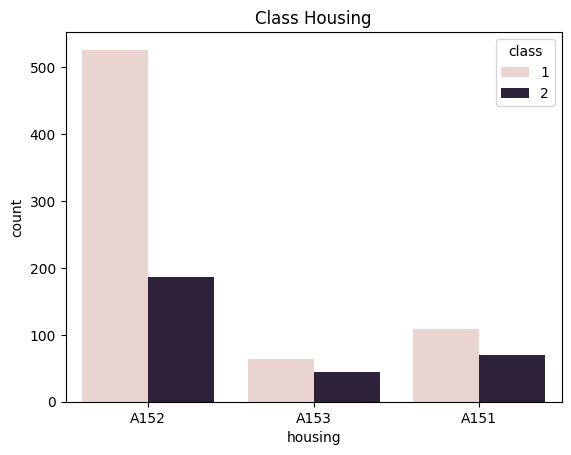

In [30]:
sns.countplot(data=df_encoded, x = 'housing', hue='class')
plt.title('Class Housing')
plt.show();

	      Housing
	      A151 : rent
	      A152 : own
	      A153 : for free

***Owning a home is an important factor for credit approval and usully homeowners need to have a 'decent' credit to own a home***

In [31]:
df_encoded = pd.get_dummies(df_encoded, columns=['housing'], prefix='housing') 

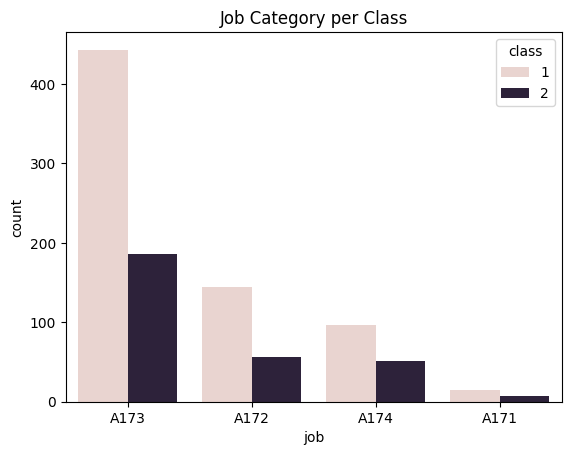

In [32]:
sns.countplot(data=df_encoded, x = 'job', hue = 'class' )
plt.title('Job Category per Class')
plt.show();


   			Job
	      A171 : unemployed/ unskilled  - non-resident
	      A172 : unskilled - resident
	      A173 : skilled employee / official
	      A174 : management/ self-employed/
		     highly qualified employee/ officer

***The distribution for each class and employment seems proportional, we can omit this category***

In [33]:
df_encoded = pd.get_dummies(df_encoded, columns=['job'], prefix='job') 

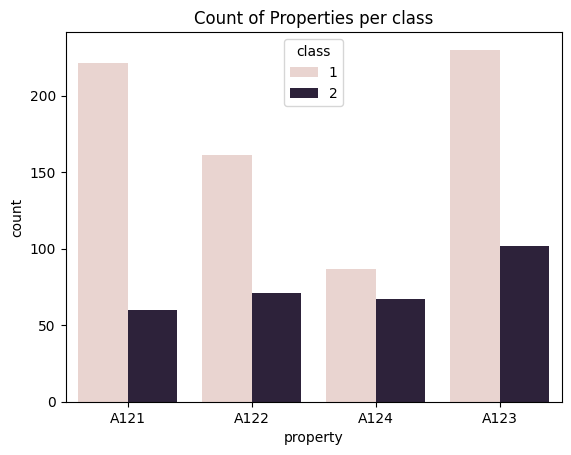

In [34]:
sns.countplot(data=df_encoded, x  = 'property', hue = 'class')
plt.title('Count of Properties per class')
plt.show();

Property

A121 : real estate

A122 : if not A121 : building society savings agreement/life insurance

A123 : if not A121/A122 : car or other, not in attribute 6

A124 : unknown / no property

***Encoding this feature because banks tend to look at collaterals when applying for credit lines***

In [35]:
df_encoded = pd.get_dummies(df_encoded, columns=['property'], prefix='property') 

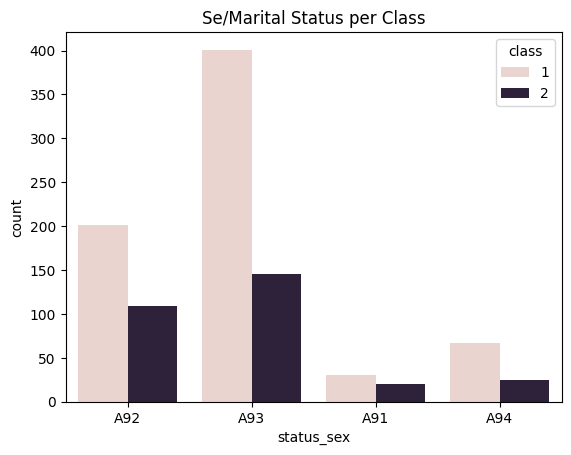

In [36]:
sns.countplot(data=df_encoded, x  = 'status_sex', hue = 'class')
plt.title('Se/Marital Status per Class')
plt.show();

	      Personal status and sex
	      A91 : male   : divorced/separated
	      A92 : female : divorced/separated/married
              A93 : male   : single
	      A94 : male   : married/widowed
	      A95 : female : single

***Encoding this feature becasue you can tell there is a difference betweeing goo/bad credit between male and females***

In [37]:
df_encoded = pd.get_dummies(df_encoded, columns=['status_sex'], prefix='status_sex') 

<Axes: xlabel='present_employment', ylabel='count'>

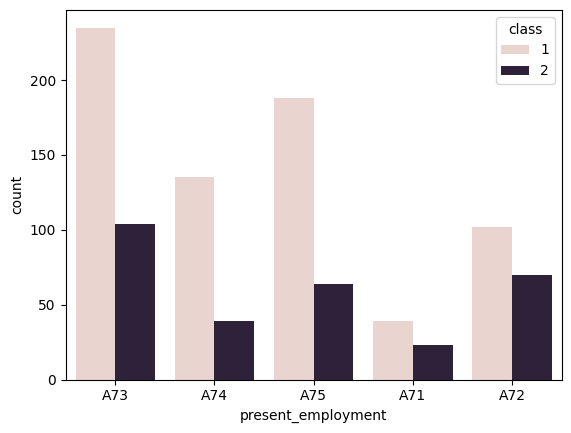

In [38]:
sns.countplot(data=df_encoded, x  = 'present_employment', hue = 'class')

      A71 : unemployed
	      A72 :       ... < 1 year
	      A73 : 1  <= ... < 4 years  
	      A74 : 4  <= ... < 7 years
	      A75 :       .. >= 7 years

***Encoding this feature becasue it is important to have a working history that is stable, it could determine you eligibility for a credit line (domain knowledge)***

In [39]:
df_encoded = pd.get_dummies(df_encoded, columns=['present_employment'], prefix='years_in employment') 

<Axes: xlabel='other_installments', ylabel='count'>

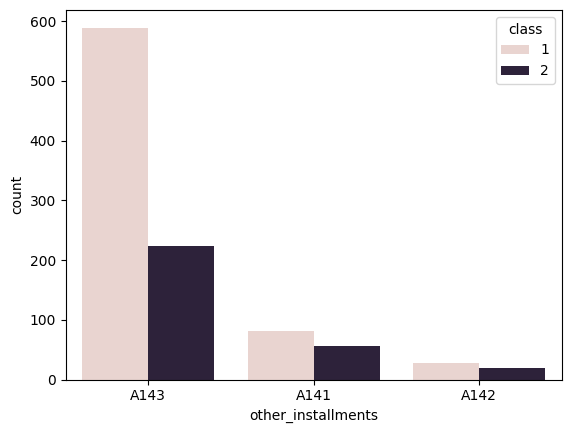

In [40]:
sns.countplot(data=df_encoded, x  = 'other_installments', hue = 'class')

     Other installment plans 
	      A141 : bank
	      A142 : stores
	      A143 : none

***Having Other Installments does not seem that affect wether you have good or bad credit,since the population results look proportional***

In [41]:
#df_encoded = pd.get_dummies(df_encoded, columns=['other_installments'], prefix='other_installments') 
df_encoded = df_encoded.drop(columns='other_installments', axis= 1)

In [42]:
pd.set_option('display.max_columns', None)

df_encoded.head(1)

,duration_month,credit_amount,disposable_income_percent,age,class,credit_purpose_A40,credit_purpose_A41,credit_purpose_A410,credit_purpose_A42,credit_purpose_A43,credit_purpose_A44,credit_purpose_A45,credit_purpose_A46,credit_purpose_A48,credit_purpose_A49,Foreign_A202,credit_history_A30,credit_history_A31,credit_history_A32,credit_history_A33,credit_history_A34,checking_account_A11,checking_account_A12,checking_account_A13,checking_account_A14,savings_account_A61,savings_account_A62,savings_account_A63,savings_account_A64,savings_account_A65,current_bank_credit_1,current_bank_credit_2,current_bank_credit_3,current_bank_credit_4,housing_A151,housing_A152,housing_A153,job_A171,job_A172,job_A173,job_A174,property_A121,property_A122,property_A123,property_A124,status_sex_A91,status_sex_A92,status_sex_A93,status_sex_A94,years_in employment_A71,years_in employment_A72,years_in employment_A73,years_in employment_A74,years_in employment_A75
0,48,5951,2,22,2,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,True,False,False,False,False,True,False,False,False,False,True,False,False,False,True,False,True,False,False,False,False,True,False,False,False,False,True,False,False


## Machine Learning

In [43]:
#1 is Good, 0 is bad
mapping_dict = {1: 1, 2: 0}
df_encoded['class'] = df_encoded['class'].map(mapping_dict)

#Seperating Features from Target
x = df_encoded.drop(columns='class',axis =1)
y = df_encoded['class']

## Naive Bayes Algorithm With Standardization

## Naive Bayes Algorithm With Standardization

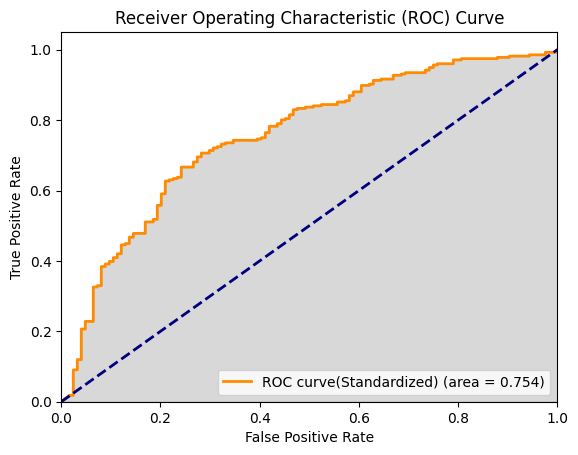

Confusion Matrix


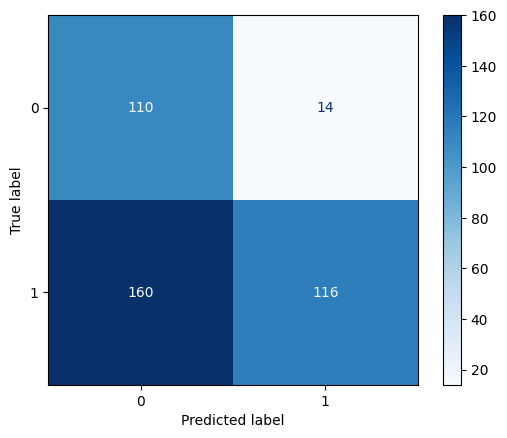

---------------------------
Performance Measures
---------------------------
Precision:, 0.8923076923076924
Recall:, 0.42028985507246375
F1 Score:, 0.5714285714285715
Accuracy Score: 0.565
-----------------------------
Hyperparameter Tuning Results
----------------------------
Best parameters:, {'var_smoothing': 0.0001}
Best score:", 0.5459604519774012
False Positive rate: 0.11290322580645161


In [44]:
#Splitting
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size= .60, random_state= 42)

#Standardizing
scaler = StandardScaler()
xtrain_scale = scaler.fit_transform(x_train)
xtest = scaler.transform(x_test)

# Hyperparameter Tuning
param_grid = {'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4]}
grid_search = GridSearchCV(estimator=GaussianNB(), param_grid=param_grid, cv=10, scoring='accuracy')
grid_search.fit(xtrain_scale, y_train)

# Training
n_b_best = grid_search.best_estimator_
n_b_best.fit(xtrain_scale, y_train)
predictions = n_b_best.predict(xtest)

#Performance
scores = n_b_best.score(xtest, y_test)
conf_mtrx = confusion_matrix(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mtrx)

#Plotting ROC Curve
y_pred_proba = n_b_best.predict_proba(xtest)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba, pos_label=1)
roc_auc = auc(fpr, tpr)

#Results
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve(Standardized) (area = {round(roc_auc,3)})')
plt.fill_between(fpr, tpr, color='gray', alpha=0.3) 
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show();
print('Confusion Matrix')
disp.plot(cmap='Blues', include_values=True)
plt.show();

print('---------------------------')
print('Performance Measures')
print('---------------------------')
print(f'Precision:, {precision}')
print(f'Recall:, {recall}')
print(f'F1 Score:, {f1}')
print(f'Accuracy Score: {scores}')
print('-----------------------------')
print('Hyperparameter Tuning Results')
print('----------------------------')
print(f'Best parameters:, {grid_search.best_params_}')
print(f'Best score:", {grid_search.best_score_}')
print(f'False Positive rate: {conf_mtrx[0][1] / (conf_mtrx[0][1]+conf_mtrx[0][0])}')

***Observation***

- The precision on this model is very good buta bit "off-balance" with the Recall score, we are trying to minimize the False Positives and this model tends to do that as well. The problem can arise from the imbalanced data.

### Simulating Best Score

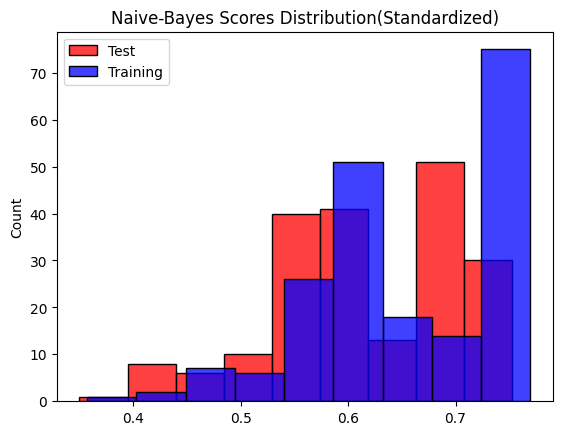

Mean Train Score: 0.6526043405676127
Mean Test Score: 0.6188
Mean Diff score: 0.03380434056761269


In [45]:
i = 0

n_b_train_score = []
n_b_test_score = []
diff = []

while i < 200:

    # Splitting
    x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=.60)

    # Standardizing
    scaler = StandardScaler()
    xtrain_scale = scaler.fit_transform(x_train)
    xtest = scaler.transform(x_test)

    # Hyperparameter Tuning
    param_grid = {'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4]}
    grid_search = GridSearchCV(estimator=GaussianNB(), param_grid=param_grid, cv=10, scoring='accuracy')
    grid_search.fit(xtrain_scale, y_train)

    # Training
    n_b_best = grid_search.best_estimator_
    n_b_best.fit(xtrain_scale, y_train)
    predictions = n_b_best.predict(xtest)

    # Performance
    train_score = n_b_best.score(xtrain_scale, y_train)
    test_score = n_b_best.score(xtest, y_test)
    n_b_train_score.append(train_score)
    n_b_test_score.append(test_score)
    diff_Score = train_score - test_score

    diff.append(diff_Score)

    i +=1 


sns.histplot(data= n_b_test_score, color = 'red', label = 'Test')
sns.histplot(data= n_b_train_score, color = 'blue', label ='Training')
plt.title('Naive-Bayes Scores Distribution(Standardized)')
plt.legend()
plt.show();
print(f'Mean Train Score: {np.mean(n_b_train_score)}')
print(f'Mean Test Score: {np.mean(n_b_test_score)}')
print(f'Mean Diff score: {np.mean(diff)}')


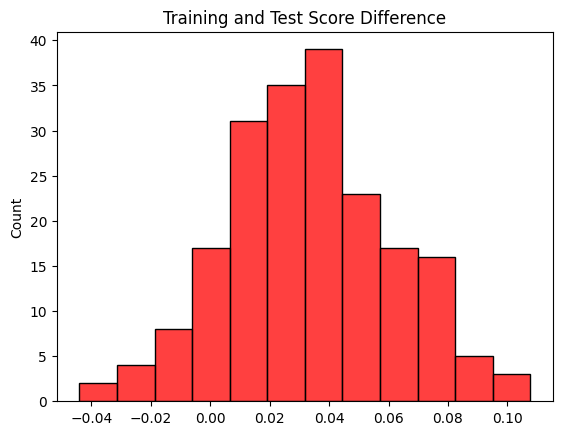

In [46]:
sns.histplot(data= diff, color = 'red')
plt.title('Training and Test Score Difference')
plt.show();


***Observation***
- From the simulations we can see that our score is very large spread and it is skewed to the left, the mean difference of our score is very close to zero indicating that our model is performing well, but like I mentioned before, it could be that the model is not learning well due to the imblanced dataset, the spread is quite high as well and the difference of score having a negative means that the model is performing  better  on the test stet rather than the training set which is preferable.

## Naive Bayes Algorithm with Balanced Target and Standardized

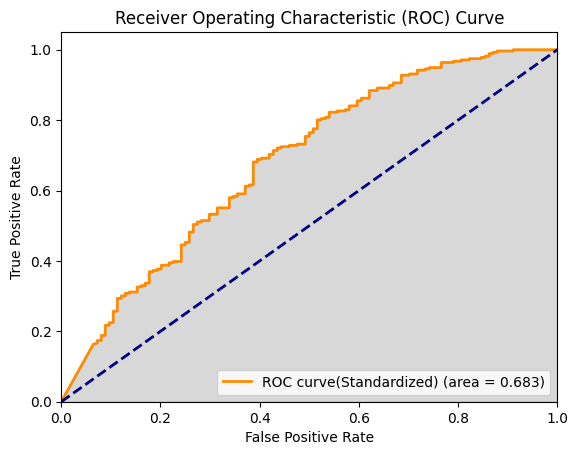

Confusion Matrix


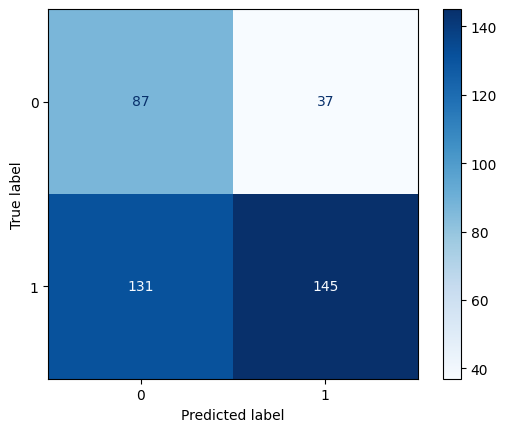

---------------------------
Performance Measures
---------------------------
Precision:, 0.7967032967032966
Recall:, 0.5253623188405797
F1 Score:, 0.6331877729257642
Accuracy Score: 0.58
-----------------------------
Hyperparameter Tuning Results
----------------------------
Best parameters:, {'var_smoothing': 0.0001}
Best score:", 0.7036274509803921
False Positive rate: 0.29838709677419356


In [47]:
#Splitting
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size= .60, random_state= 42)

#Balancing
smote = SMOTE()
x_train_, y_train_ =  smote.fit_resample(x_train,y_train)

#Standardizing
scaler = StandardScaler()
xtrain_scale = scaler.fit_transform(x_train_)
xtest = scaler.transform(x_test)

# Hyperparameter Tuning
param_grid = {'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4]}
grid_search = GridSearchCV(estimator=GaussianNB(), param_grid=param_grid, cv=10, scoring='accuracy')
grid_search.fit(xtrain_scale, y_train_)

# Training
n_b_best = grid_search.best_estimator_
n_b_best.fit(xtrain_scale, y_train_)
predictions= n_b_best.predict(xtest)

#Performance
scores = n_b_best.score(xtest, y_test)
conf_mtrx = confusion_matrix(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mtrx)

#Plotting ROC Curve
y_pred_proba = n_b_best.predict_proba(xtest)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba, pos_label=1)
roc_auc = auc(fpr, tpr)

#Results
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve(Standardized) (area = {round(roc_auc,3)})')
plt.fill_between(fpr, tpr, color='gray', alpha=0.3) 
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show();
print('Confusion Matrix')
disp.plot(cmap='Blues', include_values=True)
plt.show();

print('---------------------------')
print('Performance Measures')
print('---------------------------')
print(f'Precision:, {precision}')
print(f'Recall:, {recall}')
print(f'F1 Score:, {f1}')
print(f'Accuracy Score: {scores}')
print('-----------------------------')
print('Hyperparameter Tuning Results')
print('----------------------------')
print(f'Best parameters:, {grid_search.best_params_}')
print(f'Best score:", {grid_search.best_score_}')
print(f'False Positive rate: {conf_mtrx[0][1] / (conf_mtrx[0][1]+conf_mtrx[0][0])}')

***Observations***

- Precision has dropped but recall has increased, this means that our model has a good proportion of having large true positives while also making correct predictions.  Our Falsse Positive Rate has increased but it is balanced with the Recall score. The AUC is near the 50/50 threshold, it could potentiall cause issue if our model is slightly "guessing" the predictions. 

### Simulating Best Score

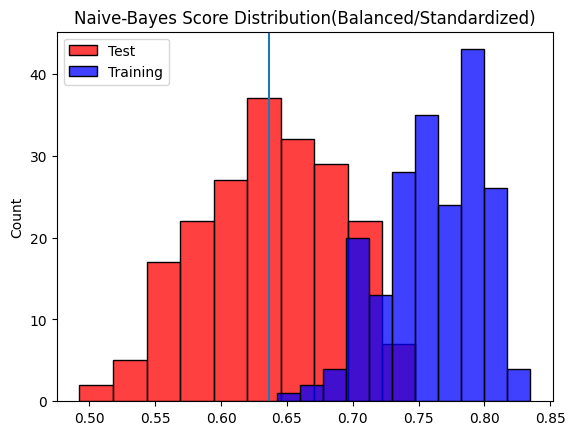

Mean Train Score: 0.7613503506872331
Mean Test Score: 0.6362875
Mean Diff score: 0.12506285068723313


In [48]:
i = 0
n_b_train_score = []
n_b_test_score = []
diff = []


while i < 200:

    #Splitting
    x_train, x_test, y_train, y_test = train_test_split(x, y, train_size= .60)
    
   #Balancing
    smote = SMOTE()
    x_train_, y_train_ =  smote.fit_resample(x_train,y_train)
    
    #Standardizing
    scaler = StandardScaler()
    xtrain_scale = scaler.fit_transform(x_train_)
    xtest = scaler.transform(x_test)
    
    # Hyperparameter Tuning
    param_grid = {'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4]}
    grid_search = GridSearchCV(estimator=GaussianNB(), param_grid=param_grid, cv=10, scoring='accuracy')
    grid_search.fit(xtrain_scale, y_train_)
    

    # Training
    n_b_best = grid_search.best_estimator_
    n_b_best.fit(xtrain_scale, y_train_)
    predictions = n_b_best.predict(xtest)

    # Performance
    train_score = n_b_best.score(xtrain_scale, y_train_)
    test_score = n_b_best.score(xtest, y_test)
    n_b_train_score.append(train_score)
    n_b_test_score.append(test_score)
    diff_Score = train_score - test_score

    diff.append(diff_Score)

    i +=1 


sns.histplot(data= n_b_test_score, color = 'red', label = 'Test')
sns.histplot(data= n_b_train_score, color = 'blue', label ='Training')
plt.title('Naive-Bayes Score Distribution(Balanced/Standardized)')
plt.legend()
plt.axvline(np.mean(n_b_test_score))
plt.show();

print(f'Mean Train Score: {np.mean(n_b_train_score)}')
print(f'Mean Test Score: {np.mean(n_b_test_score)}')
print(f'Mean Diff score: {np.mean(diff)}')


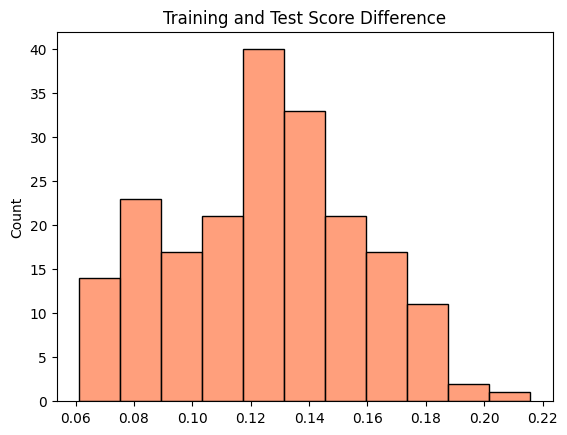

In [49]:
sns.histplot(data = diff, color ='coral')
plt.title('Training and Test Score Difference')
plt.show();

***Observation***
- In comparison to the previous simulation, this model is doing better on the training data, which could also be a sign of overfitting. 

## Without modifications to the dataset

Confusion Matrix


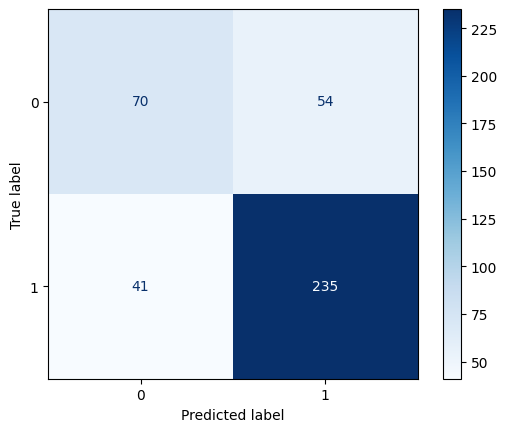

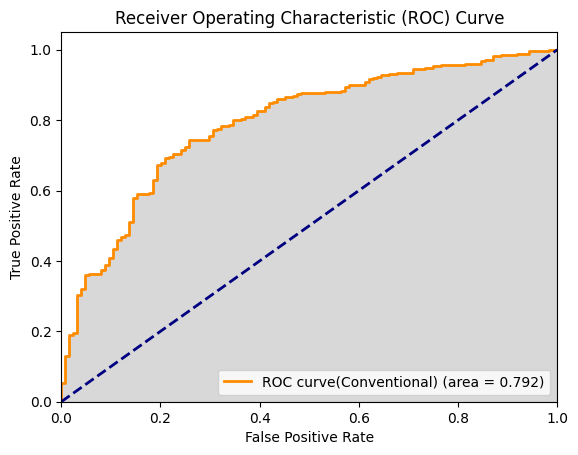

---------------------------
Performance Measures
---------------------------
Precision:, 0.8131487889273357
Recall:, 0.8514492753623188
F1 Score:, 0.831858407079646
Accuracy Score: 0.7625
-----------------------------
Hyperparameter Tuning Results
----------------------------
Best parameters:, {'var_smoothing': 1e-08}
Best score:", 0.7495762711864407
False Positive rate: 0.43548387096774194


In [50]:
#Splitting
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size= .60, random_state= 42)

# Hyperparameter Tuning
param_grid = {'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4]}
grid_search = GridSearchCV(estimator=GaussianNB(), param_grid=param_grid, cv=10, scoring='accuracy')
grid_search.fit(x_train, y_train)

# Training
n_b_best = grid_search.best_estimator_
n_b_best.fit(x_train, y_train)
predictions_ = n_b_best.predict(x_test)

#Performance
scores = n_b_best.score(x_test, y_test)
conf_mtrx = confusion_matrix(y_test, predictions_)
precision = precision_score(y_test, predictions_)
recall = recall_score(y_test, predictions_)
f1 = f1_score(y_test, predictions_)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mtrx)

#Results
print('Confusion Matrix')
disp.plot(cmap='Blues', include_values=True)
plt.show();


#Plotting ROC Curve
y_pred_proba = n_b_best.predict_proba(x_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba, pos_label=1)
roc_auc = auc(fpr, tpr)


plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve(Conventional) (area = {round(roc_auc,3)})')
plt.fill_between(fpr, tpr, color='gray', alpha=0.3) 
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show();

print('---------------------------')
print('Performance Measures')
print('---------------------------')
print(f'Precision:, {precision}')
print(f'Recall:, {recall}')
print(f'F1 Score:, {f1}')
print(f'Accuracy Score: {scores}')
print('-----------------------------')
print('Hyperparameter Tuning Results')
print('----------------------------')
print(f'Best parameters:, {grid_search.best_params_}')
print(f'Best score:", {grid_search.best_score_}')
print(f'False Positive rate: {conf_mtrx[0][1] / (conf_mtrx[0][1]+conf_mtrx[0][0])}')

***Observations***

- We got higher results by leaving the model intact, no standardization and no balance dataset. Our AUC is close to .80, a percentage that can be categorized as a good performing model. The ratio of precision and recall or F1 score is above .80 which means that our model is good a predicting a high number of True Positives without sacrificing its accuracy. Overall this model can be a candidate. 

### Simulating Best Score

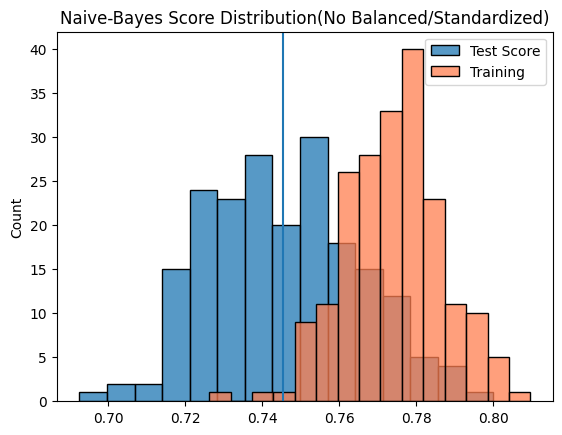

Mean Train Score: 0.7738564273789649
Mean Test Score: 0.7453624999999999
Mean Diff score: 0.02849392737896494


In [51]:
i = 0
n_b_train_score = []
n_b_test_score = []
diff = []

while i < 200:
    
    #Splitting
    x_train, x_test, y_train, y_test = train_test_split(x, y, train_size= .60)
    
    # Hyperparameter Tuning
    param_grid = {'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4]}
    grid_search = GridSearchCV(estimator=GaussianNB(), param_grid=param_grid, cv=10, scoring='accuracy')
    grid_search.fit(x_train, y_train)
    
    # Training
    n_b_best = grid_search.best_estimator_
    n_b_best.fit(x_train, y_train)
    predictions = n_b_best.predict(x_test)

    # Performance
    train_score = n_b_best.score(x_train, y_train)
    test_score = n_b_best.score(x_test, y_test)
    n_b_train_score.append(train_score)
    n_b_test_score.append(test_score)
    diff_score = train_score - test_score
    diff.append(diff_score)

    i +=1 


sns.histplot(data=n_b_test_score, bins=15, label ='Test Score')
sns.histplot(data = n_b_train_score, bins = 15, color = 'coral', label = 'Training')
plt.title('Naive-Bayes Score Distribution(No Balanced/Standardized)')
plt.legend()
plt.axvline(np.mean(n_b_test_score))
plt.show();

print(f'Mean Train Score: {np.mean(n_b_train_score)}')
print(f'Mean Test Score: {np.mean(n_b_test_score)}')
print(f'Mean Diff score: {np.mean(diff)}')


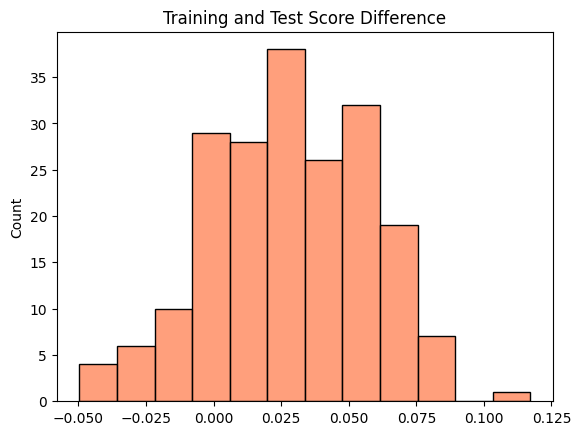

In [52]:
sns.histplot(data = diff, color = 'coral')
plt.title('Training and Test Score Difference')
plt.show();

The difference in scores has a range with negative numbers, again, it is an observation that our models is performing better on our test set rather than our training set. 

## With Balanced Target And No Standardization

Confusion Matrix


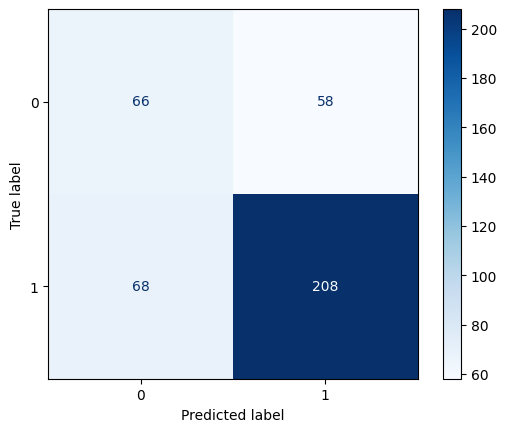

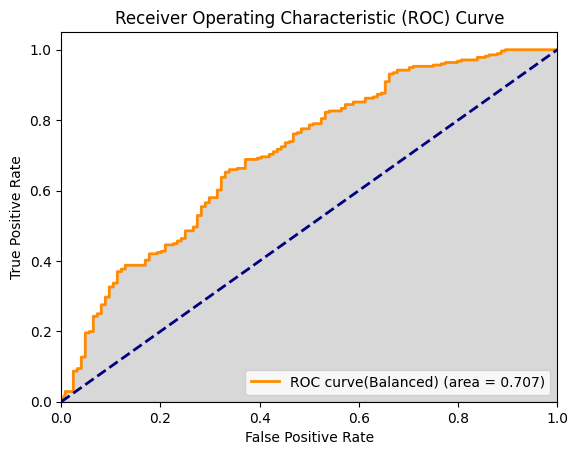

---------------------------
Performance Measures
---------------------------
Precision:, 0.7819548872180451
Recall:, 0.7536231884057971
F1 Score:, 0.7675276752767528
Accuracy Score: 0.685
-----------------------------
Hyperparameter Tuning Results
----------------------------
Best parameters:, {'var_smoothing': 1e-09}
Best score:", 0.7734733893557422
False Positive rate: 0.46774193548387094


In [53]:

#Splitting
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size= .60, random_state=42)

#Balancing
smote = SMOTE()
x_train_, y_train_ =  smote.fit_resample(x_train,y_train)


# Hyperparameter Tuning
param_grid = {'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4]}
grid_search = GridSearchCV(estimator=GaussianNB(), param_grid=param_grid, cv=10, scoring='accuracy')
grid_search.fit(x_train_, y_train_)

# Training
n_b_best = grid_search.best_estimator_
n_b_best.fit(x_train_, y_train_)
predictions_ = n_b_best.predict(x_test)

#Performance
scores = n_b_best.score(x_test, y_test)
conf_mtrx = confusion_matrix(y_test, predictions_)
precision = precision_score(y_test, predictions_)
recall = recall_score(y_test, predictions_)
f1 = f1_score(y_test, predictions_)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mtrx)

#Results
print('Confusion Matrix')
disp.plot(cmap='Blues', include_values=True)
plt.show();


#Plotting ROC Curve
y_pred_proba = n_b_best.predict_proba(x_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba, pos_label=1)
roc_auc = auc(fpr, tpr)


plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve(Balanced) (area = {round(roc_auc,3)})')
plt.fill_between(fpr, tpr, color='gray', alpha=0.3) 
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show();

print('---------------------------')
print('Performance Measures')
print('---------------------------')
print(f'Precision:, {precision}')
print(f'Recall:, {recall}')
print(f'F1 Score:, {f1}')
print(f'Accuracy Score: {scores}')
print('-----------------------------')
print('Hyperparameter Tuning Results')
print('----------------------------')
print(f'Best parameters:, {grid_search.best_params_}')
print(f'Best score:", {grid_search.best_score_}')
print(f'False Positive rate: {conf_mtrx[0][1] / (conf_mtrx[0][1]+conf_mtrx[0][0])}')

This model performed very similar to the convential  algorithm except the score were lowere but that ratio is consistent, give then results from the previous model we can discard this one. 

### Simulating Best Score

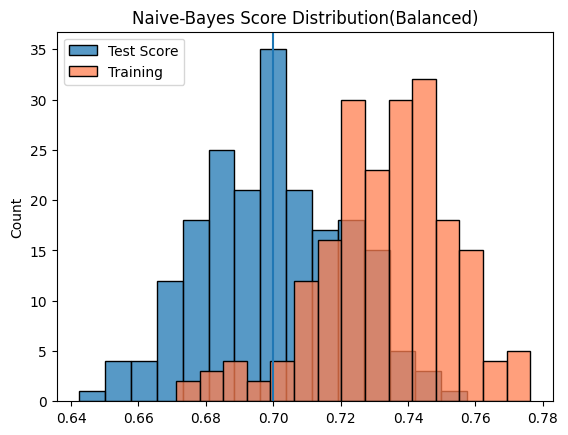

Mean Train Score: 0.7332220367278798
Mean Test Score: 0.6999875
Mean Diff score: 0.0332345367278798


In [54]:
i = 0
n_b_score = []
n_b_train_score = []
n_b_test_score = []
diff = []

while i < 200:
    
    #Splitting
    x_train, x_test, y_train, y_test = train_test_split(x, y, train_size= .60)

    #Balancing
    smote = SMOTE()
    x_train_, y_train_ =  smote.fit_resample(x_train,y_train)


    # Hyperparameter Tuning
    param_grid = {'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4]}
    grid_search = GridSearchCV(estimator=GaussianNB(), param_grid=param_grid, cv=10, scoring='accuracy')
    grid_search.fit(x_train_, y_train_)

    # Training
    n_b_best = grid_search.best_estimator_
    n_b_best.fit(x_train_, y_train_)
    predictions_ = n_b_best.predict(x_test)
    
    # Performance
    train_score = n_b_best.score(x_train, y_train)
    test_score = n_b_best.score(x_test, y_test)
    n_b_train_score.append(train_score)
    n_b_test_score.append(test_score)
    diff_score = train_score - test_score
    diff.append(diff_score)

    i +=1 


sns.histplot(data=n_b_test_score, bins=15, label ='Test Score')
sns.histplot(data = n_b_train_score, bins = 15, color = 'coral', label = 'Training')
plt.title('Naive-Bayes Score Distribution(Balanced)')
plt.legend()
plt.axvline(np.mean(n_b_test_score))
plt.show();

print(f'Mean Train Score: {np.mean(n_b_train_score)}')
print(f'Mean Test Score: {np.mean(n_b_test_score)}')
print(f'Mean Diff score: {np.mean(diff)}')

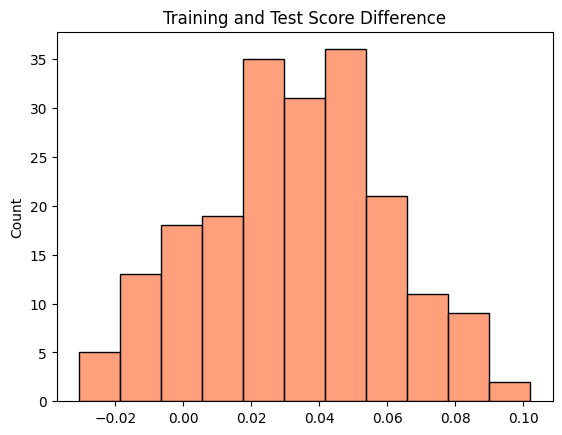

In [55]:
sns.histplot(data = diff, color = 'coral')
plt.title('Training and Test Score Difference')
plt.show();

The abrupt cut in the histogram to negative values means that the model can have a high level of variability in its results. Although in some instances it performs better in the test set, the count tends to be low therefore the model can have problems adapting to new data.

### Optimized Gradient Boosting Machine Implementation for Balanced Classification

Confusion Matrix


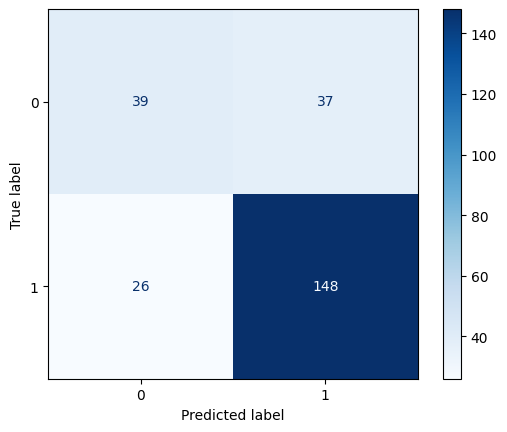

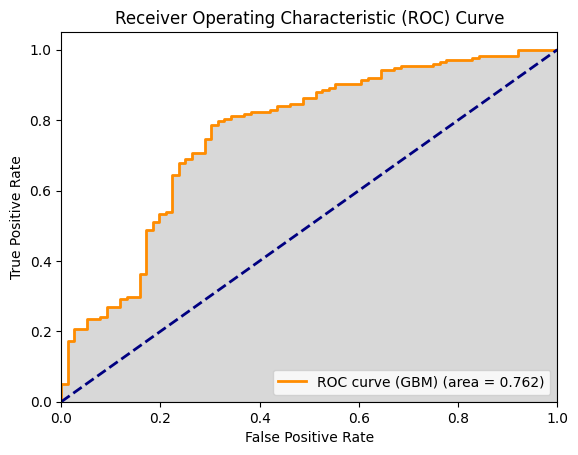

---------------------------
Performance Measures
---------------------------
Precision: 0.8
Recall: 0.8505747126436781
F1 Score: 0.8245125348189416
Accuracy Score: 0.748
-----------------------------
Hyperparameter Tuning Results
----------------------------
Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
Best score: 0.8257142857142856
False Positive rate: 0.4868421052631579


In [56]:
# Splitting
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.75)

# Balancing
smote = SMOTE()
X_resampled, Y_resampled = smote.fit_resample(x_train, y_train)


# Hyperparameter Tuning for Gradient Boosting
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of boosting stages to be run
    'learning_rate': [0.01, 0.1, 0.2],  # Shrinks the contribution of each tree by learning_rate
    'max_depth': [3, 4, 5]  # Maximum depth of the individual regression estimators
}
grid_search = GridSearchCV(estimator=GradientBoostingClassifier(), param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_resampled, Y_resampled)

# Training with the best parameters found
gbm_best = grid_search.best_estimator_
gbm_best.fit(X_resampled, Y_resampled)
predictions = gbm_best.predict(x_test)

# Performance evaluation
scores = gbm_best.score(x_test, y_test)
conf_mtrx = confusion_matrix(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)

# Confusion Matrix Display
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mtrx)
print('Confusion Matrix')
disp.plot(cmap='Blues', include_values=True)
plt.show()

# Plotting ROC Curve
y_pred_proba = gbm_best.predict_proba(x_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba, pos_label=1)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (GBM) (area = {round(roc_auc, 3)})')
plt.fill_between(fpr, tpr, color='gray', alpha=0.3)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

print('---------------------------')
print('Performance Measures')
print('---------------------------')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Accuracy Score: {scores}')
print('-----------------------------')
print('Hyperparameter Tuning Results')
print('----------------------------')
print(f'Best parameters: {grid_search.best_params_}')
print(f'Best score: {grid_search.best_score_}')
print(f'False Positive rate: {conf_mtrx[0][1] / (conf_mtrx[0][1]+conf_mtrx[0][0])}')

## GBM Result Interpretation
The Model has a high rate of prediciting true positives (Precision) and catching the majority of the total actual positives (Recall). The high F1 score indicates that the model effectively balances both metrics. The models ability to predict all True Positives and True Negatives is its weakest score, though it is still relatively high (Accuracy). Overall, the performance measures are well rounded. 

In [ ]:
# Initialize lists to store scores and differences
gbm_precision = []
gbm_recall = []
gbm_f1_score = []
gbm_accuracy = []
gbm_roc_auc = []
gbm_diff = []

# Counter
i = 0
# Number of iterations
iterations = 200

while i < iterations:
    # Data splitting
    x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.60)

    # Data balancing with SMOTE
    smote = SMOTE()
    X_resampled, Y_resampled = smote.fit_resample(x_train, y_train)

    # Hyperparameter tuning for Gradient Boosting
    param_grid = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 4, 5]
    }
    grid_search = GridSearchCV(estimator=GradientBoostingClassifier(), param_grid=param_grid, cv=10, scoring='accuracy')
    grid_search.fit(X_resampled, Y_resampled)

    # Training with the best parameters found
    gbm_best = grid_search.best_estimator_
    gbm_best.fit(X_resampled, Y_resampled)
    predictions = gbm_best.predict(x_test)

    # Performance evaluation
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    f1_score_val = f1_score(y_test, predictions)
    accuracy = gbm_best.score(x_test, y_test)
    train_score = gbm_best.score(X_resampled, Y_resampled)
    
    # Difference in training and testing accuracy
    diff_score = train_score - accuracy

    # Store scores
    gbm_precision.append(precision)
    gbm_recall.append(recall)
    gbm_f1_score.append(f1_score_val)
    gbm_accuracy.append(accuracy)
    gbm_diff.append(diff_score)

    # ROC Curve calculations
    y_pred_proba = gbm_best.predict_proba(x_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba, pos_label=1)
    roc_auc = auc(fpr, tpr)
    gbm_roc_auc.append(roc_auc)

    i += 1

# Plotting the results
sns.histplot(data=gbm_accuracy, bins=15, label='Test Accuracy', kde=True)
sns.histplot(data=gbm_roc_auc, bins=15, color='coral', label='ROC AUC', kde=True)
plt.title('GBM Performance Distribution (Balanced)')
plt.legend()
plt.axvline(x=np.mean(gbm_accuracy), color='blue', linestyle='--', label='Average Test Accuracy')
plt.axvline(x=np.mean(gbm_roc_auc), color='coral', linestyle='--', label='Average ROC AUC')
plt.show()

# Print the average scores
print(f'Mean Precision: {np.mean(gbm_precision)}')
print(f'Mean Recall: {np.mean(gbm_recall)}')
print(f'Mean F1 Score: {np.mean(gbm_f1_score)}')
print(f'Mean Accuracy: {np.mean(gbm_accuracy)}')
print(f'Mean ROC AUC: {np.mean(gbm_roc_auc)}')
print(f'Mean Difference Score: {np.mean(gbm_diff)}')


### RandomForest Algorithm (Resetted df)
We decided for the final algorithm, to reset the df and compare the results of a comparable algorithm but with much less data cleaning and feature manipulation to the previous two algorithm results to see how much of an impact our previous cleaning had yielded. 

In [59]:
# Loading dataset and setting column names

df = pd.read_csv("german.data", sep=r'\s+')
column_names = ['checking_account', 'duration_month', 'credit_history', 'credit_purpose','credit_amount','savings_account','present_employment','disposable_income_percent',
 'status_sex','debtors','residence_since','property','age','other_installments', 'housing','credits_at_current_bank','job','dependants','telephone', 'foreign_worker','class']

df.columns = column_names
df.columns

Index(['checking_account', 'duration_month', 'credit_history',
       'credit_purpose', 'credit_amount', 'savings_account',
       'present_employment', 'disposable_income_percent', 'status_sex',
       'debtors', 'residence_since', 'property', 'age', 'other_installments',
       'housing', 'credits_at_current_bank', 'job', 'dependants', 'telephone',
       'foreign_worker', 'class'],
      dtype='object')

In [60]:
# Separating "Explanatory", and "Response Variables" into separate DataFrames. 
# Then encoding categorical values and changed "Class" variable into a string since it does not represent a numerical value but is rather a category.
explanatory = df.drop(columns=['class'])
explanatory_dummies = pd.get_dummies(explanatory)
response = df['class'].astype(str).replace({'1': 'Good', '2': 'Bad'})
df.groupby(['class']).count()

,checking_account,duration_month,credit_history,credit_purpose,credit_amount,savings_account,present_employment,disposable_income_percent,status_sex,debtors,residence_since,property,age,other_installments,housing,credits_at_current_bank,job,dependants,telephone,foreign_worker
class,,,,,,,,,,,,,,,,,,,,
1,699,699,699,699,699,699,699,699,699,699,699,699,699,699,699,699,699,699,699,699
2,300,300,300,300,300,300,300,300,300,300,300,300,300,300,300,300,300,300,300,300


              precision    recall  f1-score   support

         Bad       0.59      0.40      0.48        57
        Good       0.79      0.89      0.84       143

    accuracy                           0.75       200
   macro avg       0.69      0.65      0.66       200
weighted avg       0.73      0.75      0.73       200



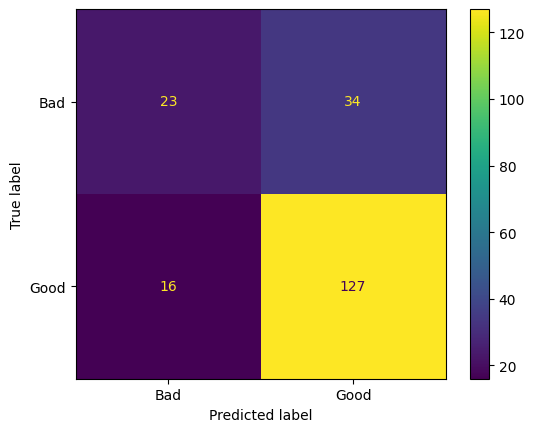

In [61]:
# Creating training and testing sets
x_train, x_test, y_train, y_test = train_test_split(explanatory_dummies, response, test_size = 0.2)
y_train_flat = np.ravel(y_train, order='C')
y_test_flat = np.ravel(y_test, order='C')

rf = RandomForestClassifier()
rf.fit(x_train, y_train_flat)

# Precision: Percent of "True Positives" identified correctly divided by all predicted positives in dataset
# Recall: Percent of positive predictions were correct.
# I'd argue the data set is unbalanced 
preds = rf.predict(x_test)
cr = classification_report(y_test, preds)
print(cr)

ConfusionMatrixDisplay.from_predictions(y_test, preds)

              precision    recall  f1-score   support

         Bad       0.60      0.44      0.51        57
        Good       0.80      0.88      0.84       143

    accuracy                           0.76       200
   macro avg       0.70      0.66      0.67       200
weighted avg       0.74      0.76      0.74       200



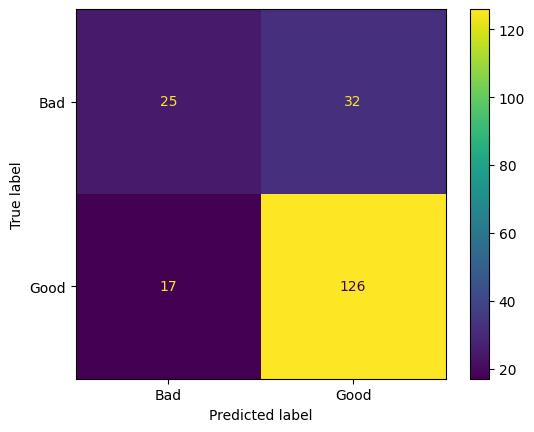

In [62]:
# Determining most important explanatory features
# Training Random Forest on new training data

feature_select = SelectFromModel(RandomForestClassifier(n_estimators = 50))
feature_select.fit(x_train, y_train)
features = feature_select.get_feature_names_out().tolist()

selected_features_train = x_train[features]
selected_features_test = x_test[features]

rf.fit(selected_features_train, y_train_flat)

# New classification report based on selected features.

preds_new_features = rf.predict(selected_features_test)
cr_feature = classification_report(y_test, preds_new_features)
print(cr_feature)

ConfusionMatrixDisplay.from_predictions(y_test, preds_new_features)

RandomForestClassifier(max_depth=12, max_features=None, max_leaf_nodes=9)
              precision    recall  f1-score   support

         Bad       0.76      0.33      0.46        57
        Good       0.78      0.96      0.86       143

    accuracy                           0.78       200
   macro avg       0.77      0.65      0.66       200
weighted avg       0.78      0.78      0.75       200



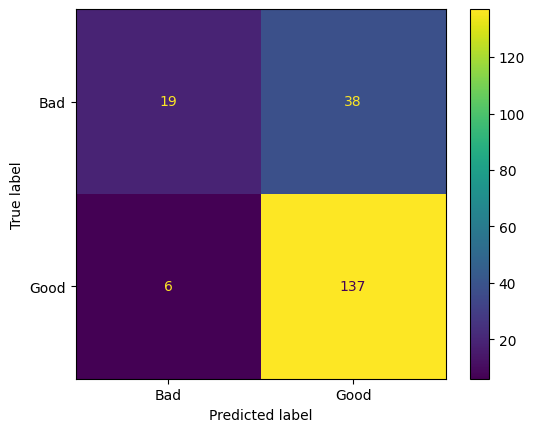

In [63]:
# Hypertuning parameters
param_grid = { 
    'n_estimators': list(np.arange(25, 200, 25)), 
    'max_features': ['sqrt', 'log2', None], 
    'max_depth': list(np.arange(3, 21, 3)), 
    'max_leaf_nodes': list(np.arange(3, 21, 3)), 
} 

search = RandomizedSearchCV(RandomForestClassifier(), param_grid) 
search.fit(selected_features_train, y_train) 
print(search.best_estimator_)

# Retraining with tuned hyperparameters
rf = RandomForestClassifier(max_depth=6, max_features='log2', max_leaf_nodes=18, n_estimators=75)
rf.fit(selected_features_train, y_train_flat)

# Predicitions with tuned hyperparameters

preds_new_features_tuned = rf.predict(selected_features_test)
cr_feature_tuned = classification_report(y_test, preds_new_features_tuned)
print(cr_feature_tuned)

ConfusionMatrixDisplay.from_predictions(y_test, preds_new_features_tuned)

### Random Forest Interpretation
The RandomForest model demonstrates a strong ability to correctly identify positive predictions (Precision) and to capture a significant portion of the actual positive cases (Recall), both with equal proficiency. The model achieves a balanced performance as evidenced by its F1 score, which is commendable though slightly lower than the individual precision and recall scores. The overall accuracy, which measures the model's effectiveness in identifying both True Positives and True Negatives, aligns closely with the other metrics, highlighting its consistency across various aspects of classification. The results indicate a robust and reliable model performance.

### Data Preparation Impact on Model Performance
RandomForest overall performance landed it in the middle of Naive Bayes and GBM. This is expected since in general, that is the order of "Performance power" of each given model. And since Random Forest still reached second place despite less data cleaning, it brings into question the overall value of the initial data cleaning. One possible reason for the lack of major difference could be the overall quality of the dat


### Conclusion